In [67]:
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
%matplotlib inline 
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import spaCy
from scipy import stats
import gensim.models
import statistics

In [3]:
#read data
faq = pd.read_csv("data.csv", encoding='latin-1')

In [ ]:
faq.shape

In [ ]:
faq.isnull().sum()

In [7]:
#keep only questions with synonims check metrices

questions = faq["Q"]
synonims = faq["S"]

no_syn = []
for i in range(synonims.shape[0]):
    if pd.isnull(synonims[i]):
        no_syn.append(i)
        
questions.drop(no_syn, inplace=True)
synonims.drop(no_syn, inplace=True)

In [8]:
#data preprocessing
#delete punctuation and stopwords

def tokenization(text):
    stopwords = nltk.corpus.stopwords.words('english')
    punctuation = ["?", "!", ".", ",", ";", ":", "...", "(", ")", "[", "]", "_", "-"]  
    text = [str(k) for k in text.values]
    sents = []
    for sent in text:
        tokenised_sent = word_tokenize(sent)
        tokenised_sent = [k for k in tokenised_sent if k not in punctuation and k not in stopwords]
        sents.append(tokenised_sent)
    return sents

words_q = tokenization(questions)
words_s = tokenization(synonims)

In [9]:
#stemmatizatoin

def stemmatization(words):
    snowball_stemmer = nltk.SnowballStemmer('english')
    stemmed = []
    for w in words:
        stemmed.append([snowball_stemmer.stem(k.lower()) for k in w])
    return stemmed

stemmed_q = stemmatization(words_q)
stemmed_s = stemmatization(words_s)

In [10]:
#first method
#bag of words for preprocessed questions

def join_fun(words): 
    text = []
    for w in words:
        text.append(' '.join(w))
    return text

words_q_ = tokenization(stemmed_q)
words_s = tokenization(stemmed_s)
text_q = join_fun(stemmed_q)
text_s = join_fun(stemmed_s)

vectorizer = CountVectorizer()
bow = vectorizer.fit(text_q + text_s)
bag_q = bow.transform(text_q).toarray()
bag_s = bow.transform(text_s).toarray()

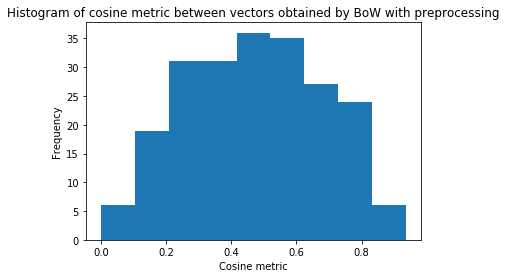

In [48]:
#using cosine similarity

def cosine(vector1, vector2):
    ab = 0
    a = 0
    b = 0
    for i in range(vector1.shape[0]):
        ab += vector1[i]*vector2[i]
        a += math.pow(vector1[i],2)
        b += math.pow(vector2[i],2)
    return ab/(math.sqrt(a)*math.sqrt(b))
    
metric = []    
for i in range(bag_q.shape[0]):
    metric.append(cosine(bag_q[i], bag_s[i]))
    
plt.hist(metric, bins='auto')
plt.title("Histogram of cosine metric between vectors obtained by BoW with preprocessing")
plt.xlabel('Cosine metric')
plt.ylabel('Frequency')
plt.show()

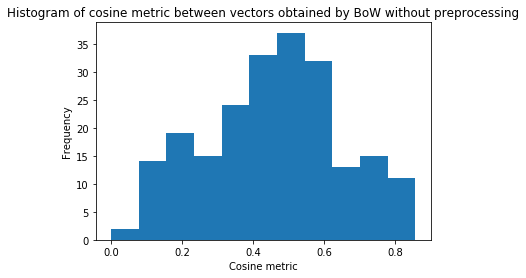

In [49]:
#bag of words for non-preprocessed questions

bow_non = vectorizer.fit(questions + synonims)
bag_q_non = bow.transform(questions).toarray()
bag_s_non = bow.transform(synonims).toarray()

metric_non = []    
for i in range(bag_q_non.shape[0]):
    metric_non.append(cosine(bag_q_non[i], bag_s_non[i]))
plt.hist(metric_non, bins = 'auto')
plt.title("Histogram of cosine metric between vectors obtained by BoW without preprocessing")
plt.xlabel('Cosine metric')
plt.ylabel('Frequency')
plt.show()

In [13]:
#use t-test to define are those options equal or not

print("Mean of cosine metric for BoW with preprocessing = ", np.mean(metric))
print("Mean of cosine metric for BoW without preprocessing = ", np.mean(metric_non))
stats.ttest_ind(metric, metric_non)

Mean of cosine metric for BoW with preprocessing =  0.4757569940049886
Mean of cosine metric for BoW without preprocessing =  0.452381327998961


Ttest_indResult(statistic=1.1953102240731248, pvalue=0.23262772295379774)

Pvalue shows that we can't regect null hypothesis about equality of those arrays. So, there are no difference, make preprocessing or not.

In [16]:
#second method
#Word2Vec 

#using Google News 300-dimensional pre-trained word embeddings
Vec = gensim.models.KeyedVectors.load_word2vec_format('.\GoogleNews-vectors-negative300.bin.gz', binary=True)

In [17]:
#export model
model = None
try:
    model = Vec.wv
    del Vec
except Exception:
    model = Vec

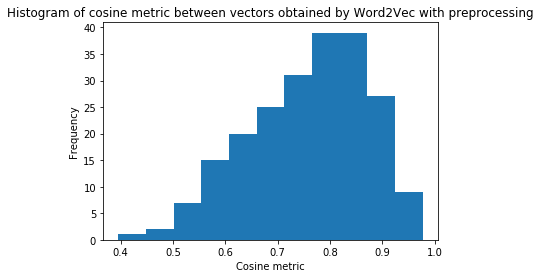

In [50]:
#sentences with preprocessing

#using mean
def getfeat(data):
    feat = []
    for i in range(len(data)):
        words = (data[i]).split(" ")
        temp = []
        for w in words:
            if w in model:
                temp.append(model[w])
        if temp:
            temp = (np.array(temp)).mean(0)
        else:
            temp = list(np.zeros(300))
        feat.append(temp)
    return feat

wordsq = tokenization(questions)
wordss = tokenization(synonims)
textq = join_fun(wordsq)
texts = join_fun(wordss)
qset = getfeat(textq)
sset = getfeat(texts)

metric_word2vec = []    
for i in range(len(q_set)):
    metric_word2vec.append(cosine(qset[i], sset[i]))
    
plt.hist(metric_word2vec, bins='auto')
plt.title("Histogram of cosine metric between vectors obtained by Word2Vec with preprocessing")
plt.xlabel('Cosine metric')
plt.ylabel('Frequency')
plt.show()

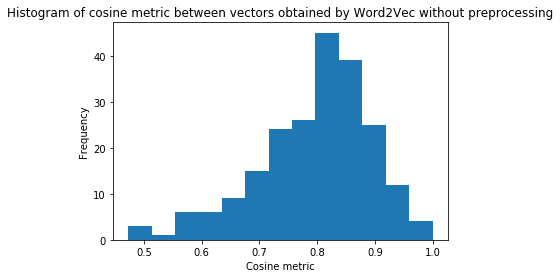

In [88]:
#sentences without preprocessing

def get_feat(data):
    feat = []
    for i in data.index:
        words = (data.loc[i]).split(" ")
        temp = []
        for w in words:
            if w in model:
                temp.append(model[w])
        if temp:
            temp = (np.array(temp)).mean(0)
        else:
            temp = list(np.zeros(300))
        feat.append(temp)
    return feat

q_set = get_feat(questions)
s_set = get_feat(synonims)

metric_word2vec_non = []    
for i in range(len(q_set)):
    metric_word2vec_non.append(cosine(q_set[i], s_set[i]))
    
plt.hist(metric_word2vec_non, bins='auto')
plt.title("Histogram of cosine metric between vectors obtained by Word2Vec without preprocessing")
plt.xlabel('Cosine metric')
plt.ylabel('Frequency')
plt.show()

In [42]:
#use t-test to define are those options equal or not

print("Mean of cosine metric for Word2Vec with preprocessing = ", np.mean(metric_word2vec))
print("Mean of cosine metric for Word2Vec without preprocessing = ", np.mean(metric_word2vec_non))
stats.ttest_ind(metric_word2vec, metric_word2vec_non)

Mean of cosine metric for Word2Vec with preprocessing =  0.7589791623658809
Mean of cosine metric for Word2Vec without preprocessing =  0.7981144958145697


Ttest_indResult(statistic=-3.7642934520429976, pvalue=0.00019033594653960117)

Pvalue shows that we can regect null hypothesis about equality of those arrays. So, there are difference, make preprocessing or not. Method without preprocessing is better, because it has bigger mean of cosine metric.

In [96]:
#using median 

#sentences with preprocessing
def getfeat_med(data):
    feat = []
    for i in range(len(data)):
        words = (data[i]).split(" ")
        temp = []
        for w in words:
            if w in model:
                temp.append(model[w])
        if temp:
            temp = np.median(np.array(temp), axis=0)
        else:
            temp = list(np.zeros(300))
        feat.append(temp)
    return feat

wordsq = tokenization(questions)
wordss = tokenization(synonims)
textq = join_fun(wordsq)
texts = join_fun(wordss)
qset = getfeat_med(textq)
sset = getfeat_med(texts)

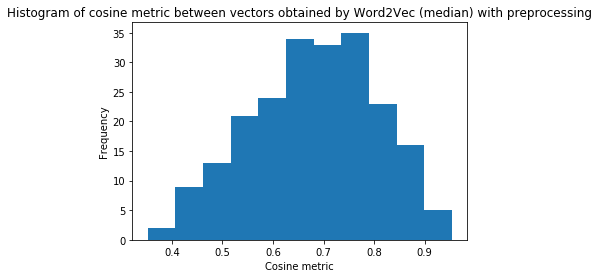

In [98]:
metric_word2vec_med = []    
for i in range(len(qset)):
    metric_word2vec_med.append(cosine(qset[i], sset[i]))
    
plt.hist(metric_word2vec_med, bins='auto')
plt.title("Histogram of cosine metric between vectors obtained by Word2Vec (median) with preprocessing")
plt.xlabel('Cosine metric')
plt.ylabel('Frequency')
plt.show()

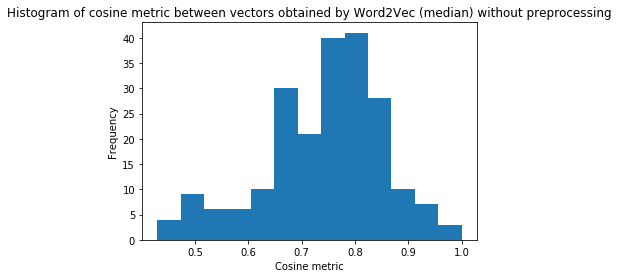

In [99]:
#sentences without preprocessing

def get_feat_med(data):
    feat = []
    for i in data.index:
        words = (data.loc[i]).split(" ")
        temp = []
        for w in words:
            if w in model:
                temp.append(model[w])
        if temp:
            temp = np.median(np.array(temp), axis=0)
        else:
            temp = list(np.zeros(300))
        feat.append(temp)
    return feat

q_set_ = get_feat_med(questions)
s_set_ = get_feat_med(synonims)

metric_word2vec_non_med = []    
for i in range(len(q_set_)):
    metric_word2vec_non_med.append(cosine(q_set_[i], s_set_[i]))
    
plt.hist(metric_word2vec_non_med, bins='auto')
plt.title("Histogram of cosine metric between vectors obtained by Word2Vec (median) without preprocessing")
plt.xlabel('Cosine metric')
plt.ylabel('Frequency')
plt.show()

In [100]:
#use t-test to define are those options equal or not

print("Mean of cosine metric for Word2Vec (median) with preprocessing = ", np.mean(metric_word2vec_med))
print("Mean of cosine metric for Word2Vec (median) without preprocessing = ", np.mean(metric_word2vec_non_med))
stats.ttest_ind(metric_word2vec_med, metric_word2vec_non_med)

Mean of cosine metric for Word2Vec (median) with preprocessing =  0.6801810921114195
Mean of cosine metric for Word2Vec (median) without preprocessing =  0.7452709643373187


Ttest_indResult(statistic=-5.697435825024312, pvalue=2.26566273031553e-08)

Pvalue shows that we can regect null hypothesis about equality of those arrays. So, there are difference, make preprocessing or not. Method without preprocessing is better, because it has bigger mean of cosine metric.

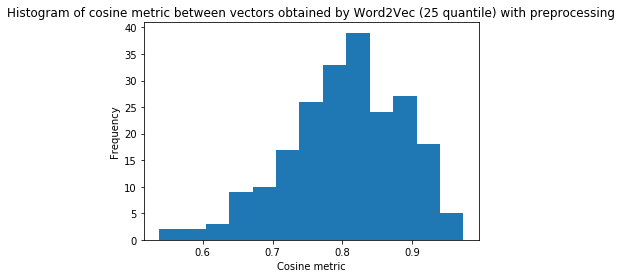

In [104]:
#using 25 and 75 quantiles 

#sentences with preprocessing
def getfeat_quan(data, q):
    feat = []
    for i in range(len(data)):
        words = (data[i]).split(" ")
        temp = []
        for w in words:
            if w in model:
                temp.append(model[w])
        if temp:
            temp = np.percentile(np.array(temp), q, axis=0)
        else:
            temp = list(np.zeros(300))
        feat.append(temp)
    return feat

wordsq_q = tokenization(questions)
wordss_q = tokenization(synonims)
textq_q = join_fun(wordsq_q)
texts_q = join_fun(wordss_q)
qset_q = getfeat_quan(textq_q, 25)
sset_q = getfeat_quan(texts_q, 25)
metric_word2vec_q25 = []    
for i in range(len(qset_q)):
    metric_word2vec_q25.append(cosine(qset_q[i], sset_q[i]))
plt.hist(metric_word2vec_q25, bins='auto')
plt.title("Histogram of cosine metric between vectors obtained by Word2Vec (25 quantile) with preprocessing")
plt.xlabel('Cosine metric')
plt.ylabel('Frequency')
plt.show()

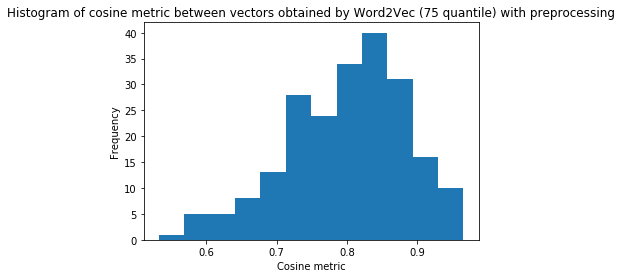

In [105]:
qset_q = getfeat_quan(textq_q, 75)
sset_q = getfeat_quan(texts_q, 75)
metric_word2vec_q75 = []    
for i in range(len(qset_q)):
    metric_word2vec_q75.append(cosine(qset_q[i], sset_q[i]))
plt.hist(metric_word2vec_q75, bins='auto')
plt.title("Histogram of cosine metric between vectors obtained by Word2Vec (75 quantile) with preprocessing")
plt.xlabel('Cosine metric')
plt.ylabel('Frequency')
plt.show()

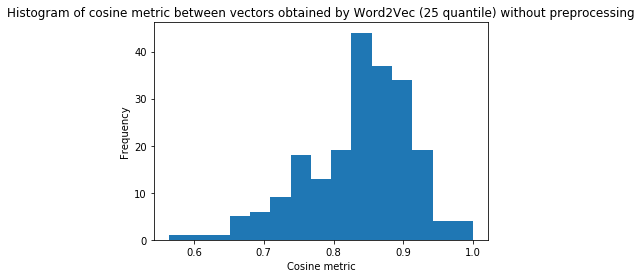

In [106]:
#sentences without preprocessing

def get_feat_quan(data, q):
    feat = []
    for i in data.index:
        words = (data.loc[i]).split(" ")
        temp = []
        for w in words:
            if w in model:
                temp.append(model[w])
        if temp:
            temp = np.percentile(np.array(temp), q, axis=0)
        else:
            temp = list(np.zeros(300))
        feat.append(temp)
    return feat

q_set_q = get_feat_quan(questions, 25)
s_set_q = get_feat_quan(synonims, 25)

metric_word2vec_non_q25 = []    
for i in range(len(q_set_q)):
    metric_word2vec_non_q25.append(cosine(q_set_q[i], s_set_q[i]))
    
plt.hist(metric_word2vec_non_q25, bins='auto')
plt.title("Histogram of cosine metric between vectors obtained by Word2Vec (25 quantile) without preprocessing")
plt.xlabel('Cosine metric')
plt.ylabel('Frequency')
plt.show()

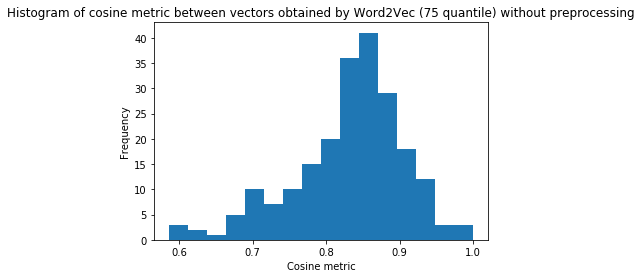

In [107]:
q_set_q = get_feat_quan(questions, 75)
s_set_q = get_feat_quan(synonims, 75)

metric_word2vec_non_q75 = []    
for i in range(len(q_set_q)):
    metric_word2vec_non_q75.append(cosine(q_set_q[i], s_set_q[i]))
    
plt.hist(metric_word2vec_non_q75, bins='auto')
plt.title("Histogram of cosine metric between vectors obtained by Word2Vec (75 quantile) without preprocessing")
plt.xlabel('Cosine metric')
plt.ylabel('Frequency')
plt.show()

In [110]:
#use t-test to define are those options equal or not

print("Mean of cosine metric for Word2Vec (25 quantile) with preprocessing = ", np.mean(metric_word2vec_q25))
print("Mean of cosine metric for Word2Vec (25 quantile) without preprocessing = ", np.mean(metric_word2vec_non_q25))
stats.ttest_ind(metric_word2vec_q25, metric_word2vec_non_q25)

Mean of cosine metric for Word2Vec (25 quantile) with preprocessing =  0.803622869626293
Mean of cosine metric for Word2Vec (25 quantile) without preprocessing =  0.837823932739729


Ttest_indResult(statistic=-4.494612226271484, pvalue=8.983109649435873e-06)

Pvalue shows that we can regect null hypothesis about equality of those arrays. So, there are difference, make preprocessing or not. Method without preprocessing is better, because it has bigger mean of cosine metric.

In [111]:
#use t-test to define are those options equal or not

print("Mean of cosine metric for Word2Vec (75 quantile) with preprocessing = ", np.mean(metric_word2vec_q75))
print("Mean of cosine metric for Word2Vec (75 quantile) without preprocessing = ", np.mean(metric_word2vec_non_q75))
stats.ttest_ind(metric_word2vec_q75, metric_word2vec_non_q75)

Mean of cosine metric for Word2Vec (75 quantile) with preprocessing =  0.7986186998719503
Mean of cosine metric for Word2Vec (75 quantile) without preprocessing =  0.8316542585905048


Ttest_indResult(statistic=-4.245362452414039, pvalue=2.6784110978366497e-05)

Pvalue shows that we can regect null hypothesis about equality of those arrays. So, there are difference, make preprocessing or not. Method without preprocessing is better, because it has bigger mean of cosine metric.

Now, we know that Word2Vec is better that BoW. For Word2Vec we define that for all cases data without preprocessing gives better results. Now, compare 4 way of calculation in Word2Vec.

In [131]:
print("Mean of cosine metric for Word2Vec (mean) without preprocessing = ", np.mean(metric_word2vec_non))
print("Mean of cosine metric for Word2Vec (median) without preprocessing = ", np.mean(metric_word2vec_non_med))
print("Mean of cosine metric for Word2Vec (25 quantile) without preprocessing = ", np.mean(metric_word2vec_non_q25))
print("Mean of cosine metric for Word2Vec (75 quantile) without preprocessing = ", np.mean(metric_word2vec_non_q75))

Mean of cosine metric for Word2Vec (mean) without preprocessing =  0.7981144958145697
Mean of cosine metric for Word2Vec (median) without preprocessing =  0.7452709643373187
Mean of cosine metric for Word2Vec (25 quantile) without preprocessing =  0.837823932739729
Mean of cosine metric for Word2Vec (75 quantile) without preprocessing =  0.8316542585905048


The biggest mean of cosine metric is when we using 25 quantile.

Results:
    - Word2Vec is better than BoW;
    - Results for data without preprocessing is better than with preprocessing;
    - To calculate vector of sentence, taking 25 quantile of vectors of words from this sentence gives bigger mean of cosine metric than mean, median and 75 quantile.

Check accuracy for those methods

In [154]:
#checking different quantiles

def sent_feat(sent, i):    
    words = sent.split(" ")
    temp = []
    for w in words:
        if w in model:
            temp.append(model[w])
    if temp:
        temp = np.percentile(np.array(temp), i, axis=0)
    else:
        temp = list(np.zeros(300))
    return np.array(temp)

for i in range(0, 100, 5):
    pred_synonims = []
    for quest in questions:
        quest_vector = sent_feat(quest, i)
        better_syn = ''
        max_cos = -100
        for syn in synonims:
            syn_vector = sent_feat(syn, i)
            cos = cosine(quest_vector, syn_vector)
            if cos > max_cos:
                max_cos = cos
                better_syn = syn    
        pred_synonims.append(better_syn)
    print("For quantile: ", i, ", accuracy of model: ", np.mean(pred_synonims == synonims))

For quantile:  0 , accuracy of model:  0.3302325581395349
For quantile:  5 , accuracy of model:  0.34418604651162793
For quantile:  10 , accuracy of model:  0.3674418604651163
For quantile:  15 , accuracy of model:  0.3627906976744186
For quantile:  20 , accuracy of model:  0.3674418604651163
For quantile:  25 , accuracy of model:  0.39069767441860465
For quantile:  30 , accuracy of model:  0.3581395348837209
For quantile:  35 , accuracy of model:  0.3302325581395349
For quantile:  40 , accuracy of model:  0.34418604651162793
For quantile:  45 , accuracy of model:  0.3488372093023256
For quantile:  50 , accuracy of model:  0.3209302325581395
For quantile:  55 , accuracy of model:  0.3395348837209302
For quantile:  60 , accuracy of model:  0.3488372093023256
For quantile:  65 , accuracy of model:  0.34418604651162793
For quantile:  70 , accuracy of model:  0.35348837209302325
For quantile:  75 , accuracy of model:  0.33488372093023255
For quantile:  80 , accuracy of model:  0.3209302325

For 25 quantile accuracy is the best.

In [155]:
def sent_feat(sent):    
    words = sent.split(" ")
    temp = []
    for w in words:
        if w in model:
            temp.append(model[w])
    if temp:
        #temp = (np.array(temp)).mean(0)
        #temp = np.median(np.array(temp), axis=0)
        #temp = np.percentile(np.array(temp), 25, axis=0)
        #combinations:
        temp = list((np.array(temp)).mean(0)) + list(np.percentile(np.array(temp), 25, axis=0))
        #temp = list((np.array(temp)).mean(0)) + list(np.median(np.array(temp), axis=0))
        #temp = list(np.median(np.array(temp), axis=0)) + list(np.percentile(np.array(temp), 25, axis=0))
        #temp = list((np.array(temp)).mean(0)) + list(np.percentile(np.array(temp), 25, axis=0)) + list(np.median(np.array(temp), axis=0))
    else:
        temp = list(np.zeros(300))
    return np.array(temp)

pred_synonims = []
for quest in questions:
    quest_vector = sent_feat(quest)
    better_syn = ''
    max_cos = -100
    for syn in synonims:
        syn_vector = sent_feat(syn)
        cos = cosine(quest_vector, syn_vector)
        if cos > max_cos:
            max_cos = cos
            better_syn = syn    
    pred_synonims.append(better_syn)
    
print("Accuracy of model: ", np.mean(pred_synonims == synonims))

Accuracy of model:  0.42790697674418604


Results for different variants:

Accuracy of model, 25 quantile:  0.39069767441860465

Accuracy of model, median:  0.3209302325581395

Accuracy of model, mean:  0.40930232558139534

Accuracy of model, mean + 25 quantile:  0.42790697674418604

Accuracy of model, mean + median:  0.3953488372093023

Accuracy of model, median + 25 quantile:  0.3674418604651163

Accuracy of model, mean + median + 25 quantile:  0.4186046511627907

Combination of mean and 25 quantile as features (we work with 600 dimensional vector, not 300d), gives the best accuracy: 0.42790697674418604